In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from PropensityScoreMatching import propensity_score_matching, double_diff_plot
import pandas as pd 
import numpy as np 

### **Introduction**

L’évaluation a posteriori de l’effet d'un traitement sur une population nécessite d’établir un contrefactuel pertinent. La définition de contrefactuel est « ce qui serait arrivé aux individus traités dans un monde parallèle où ils ne l'uaraient pas été ». Comme on n'observe pas ce monde parallèle, on cherche un « proxy » (un groupe d’entreprises effectivement observées) qui s'en approche le plus possible.

La comparaison entre les groupes d’entreprises éligibles et non éligibles implique de réaliser une « double différence », c’est à dire de mesurer dans quelle mesure l’évolution du groupe traité diverge de celle du groupe de contrôle après la mise en oeuvre de la mesure de crédit d’impôt que l’on veut évaluer. Pour être valable, une telle analyse requiert que soit vérifiée l’hypothèse selon laquelle les deux groupes auraient évolué de la même manière en l’absence de traitement.


L’appariement par score de propension permet de retrouver des entreprises non bénéficiaires aux caractéristiques proches de bénéficiaires. 
Cette méthode repose sur : 
-  l’estimation de la probabilité d’être traitée (ou score de propension) en fonction de différentes caractéristiques économiques ou géographiques
-  puis sur un appariement entre les individus traités et témoins, dont la propension à bénéficier du traitement est la plus proche, sous la contrainte qu’ils présentent certaines caractéristiques communes.



### <center> `Appariement sur séries non temporelles`

Dans ce cas, l'objectif est juste d'effectuer un appariement par score de propension sur un dataset avec des individus uniques par ligne, certains traités, d'autres non. 

#### <center> *1 - Création du dataframe de test*

In [5]:
df = pd.DataFrame({'treatment' : np.random.randint(0,2,1000), 'EBE' : np.random.normal(0, 1000000, 1000) , 'CA' : np.random.normal(0,10000000,1000)})
df.reset_index(inplace=True)

In [6]:
df.head(100)

,index,treatment,EBE,CA
0,0,0,9.296176e+05,1.883472e+07
1,1,1,2.427525e+05,-3.413390e+06
2,2,1,-8.936542e+05,-1.618545e+06
3,3,0,-9.970229e+05,1.388415e+07
4,4,0,9.505596e+04,-1.013022e+07
...,...,...,...,...
95,95,1,9.241223e+05,8.121771e+06
96,96,0,7.086721e+05,-1.036660e+07
97,97,0,-2.012602e+06,-2.198552e+07
98,98,1,-2.830054e+05,-8.809039e+06


### <center> *2 - Initialisation du Matcher*

In [7]:
matcher = propensity_score_matching.PropensityScoreMatcher(ratio = 2, var_treatment =  'treatment', id_var = "index") #Le ratio ici est de 2 non traités pour un traité, la variable indiquant 0 ou 1 selon que l'indiivdu appartienne à un groupe traité est traitement, et la colonne index permet d'identifier de manière unique les bénéficiaires. 

### <center> *3 - Regression Logistique*

Une fois le matcher initialisé, la première étape de la méthode peut être implémentée : le calcul du score de propension. Une regression logisitique est ainsi estimée sur la variable de traitement à partir de variables précisées en input. 


In [8]:
df = matcher.fit_logit_on_df(df, var_logit= ['CA', "EBE"])

Optimization terminated successfully.
         Current function value: 0.692179
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:                0.001213
Time:                        12:00:31   Log-Likelihood:                -692.18
converged:                       True   LL-Null:                       -693.02
Covariance Type:            nonrobust   LLR p-value:                    0.4315
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0366      0.063      0.577      0.564      -0.088       0.161
CA         -8.352e-09   6.48e

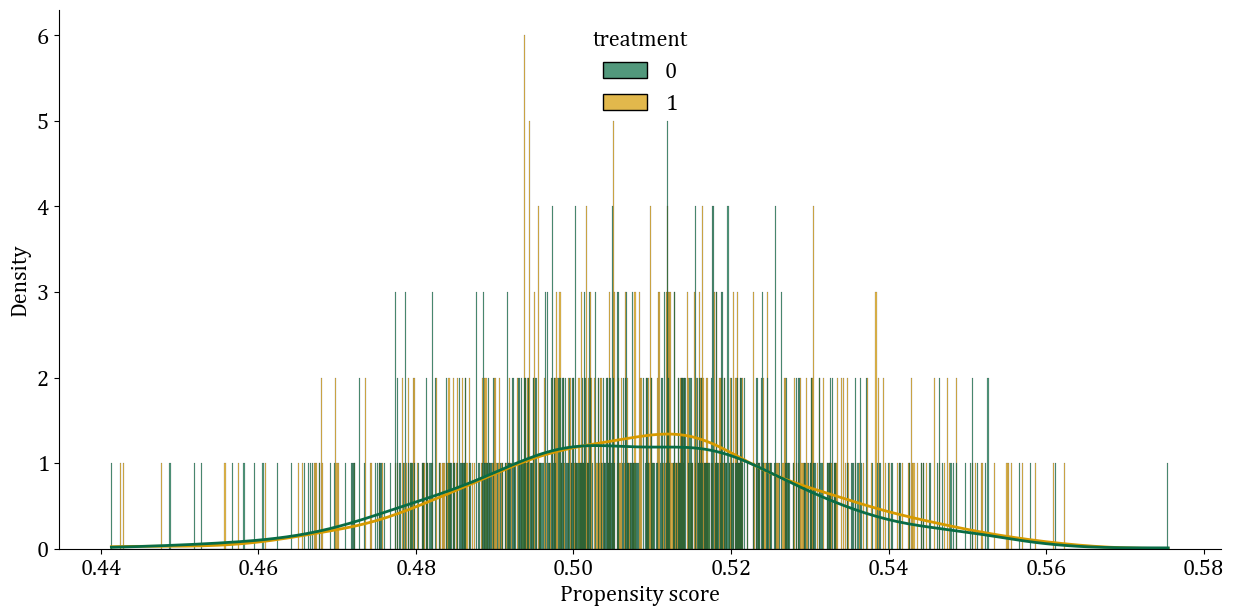

In [9]:
matcher.check_plot_common_support(df)

Il convient de vérifier qu'il existe un support commun du score de propension entre les deux groupes avant le matching. Si tel n'était pas le cas, alors une ou plusieurs variabels prises en compte dans la regression logisitque permettraient de distinguer clairement les traités des non-traités. La méthode ne pourrait pas être appliquée en l'état car il ne serait pas posisble de trouver des individus aux caractérsitiques similaires n'ayant pas été traités. 

### <center> *4 - Matching*

In [10]:
df_matched = matcher.match(df)

Processing to matching row by row: 100%|██████████| 1000/1000 [00:00<00:00, 1157.63it/s]


In [11]:
df_matched.head(20)

,index,treatment,EBE,CA,propensity_score,matched_id,to_keep_after_matching
0,0,0,9.296176e+05,1.883472e+07,0.471820,NaN,0.0
1,1,1,2.427525e+05,-3.413390e+06,0.516786,"[531, 374]",1.0
2,2,1,-8.936542e+05,-1.618545e+06,0.510640,"[788, 772]",1.0
3,3,0,-9.970229e+05,1.388415e+07,0.478066,NaN,1.0
4,4,0,9.505596e+04,-1.013022e+07,0.530468,NaN,1.0
5,5,0,1.313296e+06,-2.377818e+07,0.561270,NaN,1.0
6,6,0,1.400874e+06,5.384066e+06,0.500872,NaN,1.0
7,7,1,5.716241e+05,7.632644e+06,0.494424,"[683, 454]",1.0
8,8,0,1.097404e+05,6.070086e+06,0.496709,NaN,0.0
9,9,1,-6.993934e+05,-2.904250e+06,0.513734,"[430, 133]",1.0


         Before matching  After matching  Attrition
Treated              508             508   0.000000
Control              492             408 -20.588235
Before matching, there were 508 treated individuals and 492 control individuals
After matching, there are 508 treated individuals and 408 control individuals


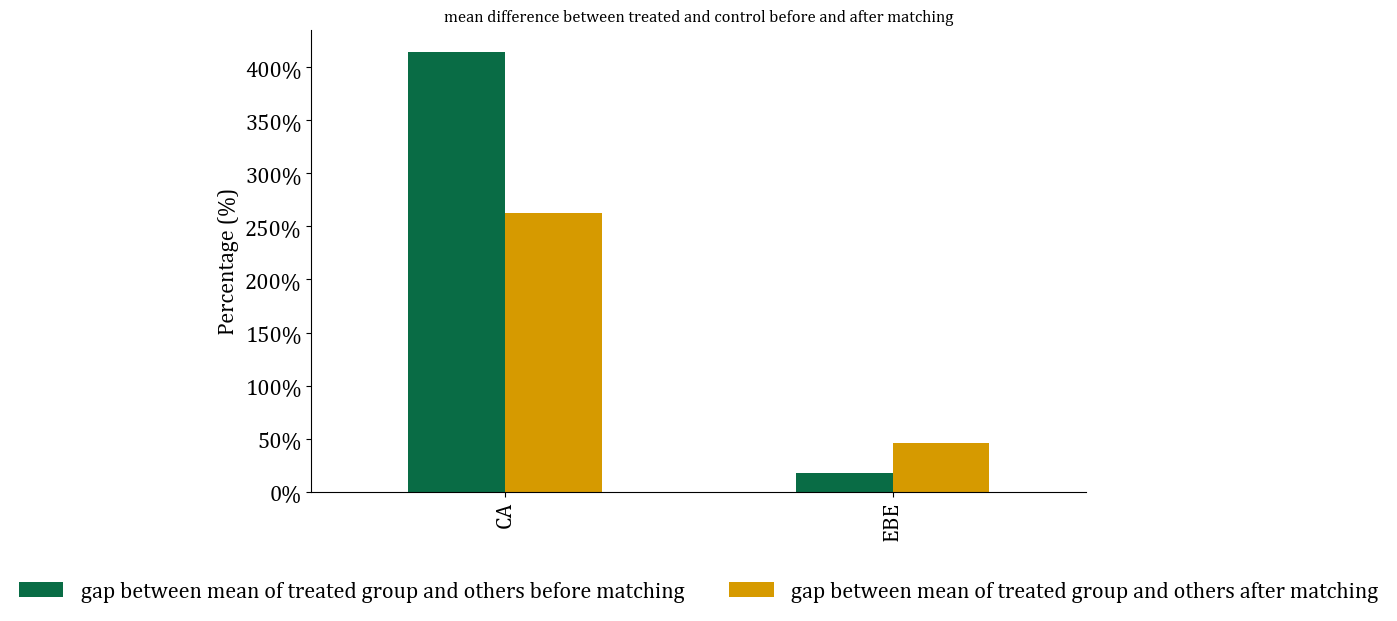

In [12]:
matcher.report(df, var_to_plot=["CA", "EBE"]) #Le tableau indiique combien de traités ont pu être effectivement matchés (le caliper en excluant certains), et combien d'individus au sein du groupe contrôle possible ont été sélectionnés avec remise

Ce graphique permet d'observer l'écart entre la moyenne du groupe traité et du groupe contrôe avant et après appariement. Ici les données sont générées aléatoirement donc le résultat ne peutpas être bon. En théorie, l'écart se réduit significatviement.

### <center> *5- Analysis*

In [13]:
df_analysis = matcher.get_dataframe_for_analysis(df_matched) #Le df en output est celui strcitement restreint aux individus à conserver pour réaliser l'analyse

In [14]:
df_analysis

,index,treatment,EBE,CA,propensity_score,matched_id,to_keep_after_matching
1,1,1,2.427525e+05,-3.413390e+06,0.516786,"[531, 374]",1.0
644,644,1,6.784705e+05,-1.252382e+06,0.513199,"[448, 859]",1.0
667,667,1,6.443675e+04,1.177557e+07,0.484705,"[910, 44]",1.0
664,664,1,2.501010e+05,-3.065604e+06,0.516076,"[893, 128]",1.0
663,663,1,5.179477e+05,7.875757e+06,0.493802,"[695, 748]",1.0
...,...,...,...,...,...,...,...
158,158,0,-1.017222e+06,-9.656641e+06,0.527138,NaN,1.0
326,326,0,1.212067e+05,-7.471064e+06,0.524987,NaN,1.0
402,402,0,-1.183405e+06,-8.841978e+06,0.525091,NaN,1.0
123,123,0,3.489504e+05,2.893415e+06,0.503848,NaN,1.0


# <center> **Appariement par score de propension sur Time Series**

La proécédure est identique mais cette fois le dataframe est une time séries indiquan tpour chaque individu un unique traitement a un moment sur la période. 

### <center> **Création d'un dataframe de test**

In [15]:
data = {'id': [], 'treatment': [], 'CA': [], 'EBE': [], 'annee': []}

for id in range(1000):
    year_of_treatment = np.random.randint(2015, 2020)
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(1 if year == year_of_treatment else 0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

for id in range(1001, 3000):
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

df = pd.DataFrame(data)

In [16]:
df

,id,treatment,CA,EBE,annee
0,0,0,-0.269369,1.052234,2015
1,0,0,-0.970757,0.756169,2016
2,0,0,0.995060,-0.011135,2017
3,0,1,-0.561805,-0.426336,2018
4,0,0,-0.375043,0.747260,2019
...,...,...,...,...,...
14990,2999,0,-0.417655,0.364607,2015
14991,2999,0,0.206953,1.331256,2016
14992,2999,0,-0.195692,-1.124095,2017
14993,2999,0,-1.063551,-0.064532,2018


### <center> **`initialisation du matcher`**

*On indique ici en plus la variable qui indique les périodes*

In [17]:
matcher = propensity_score_matching.PropensityScoreMatcherTS(ratio=2, var_treatment="treatment", time_series_var="annee", id_var="id")

### <center> **`Fit du Logit`**

In [18]:
df = matcher.fit_logit_on_df(df, ['CA', 'EBE'])

Optimization terminated successfully.
         Current function value: 0.244957
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                14995
Model:                          Logit   Df Residuals:                    14992
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:               0.0001302
Time:                        12:00:47   Log-Likelihood:                -3673.1
converged:                       True   LL-Null:                       -3673.6
Covariance Type:            nonrobust   LLR p-value:                    0.6197
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6388      0.033    -80.600      0.000      -2.703      -2.575
CA             0.0094      0.

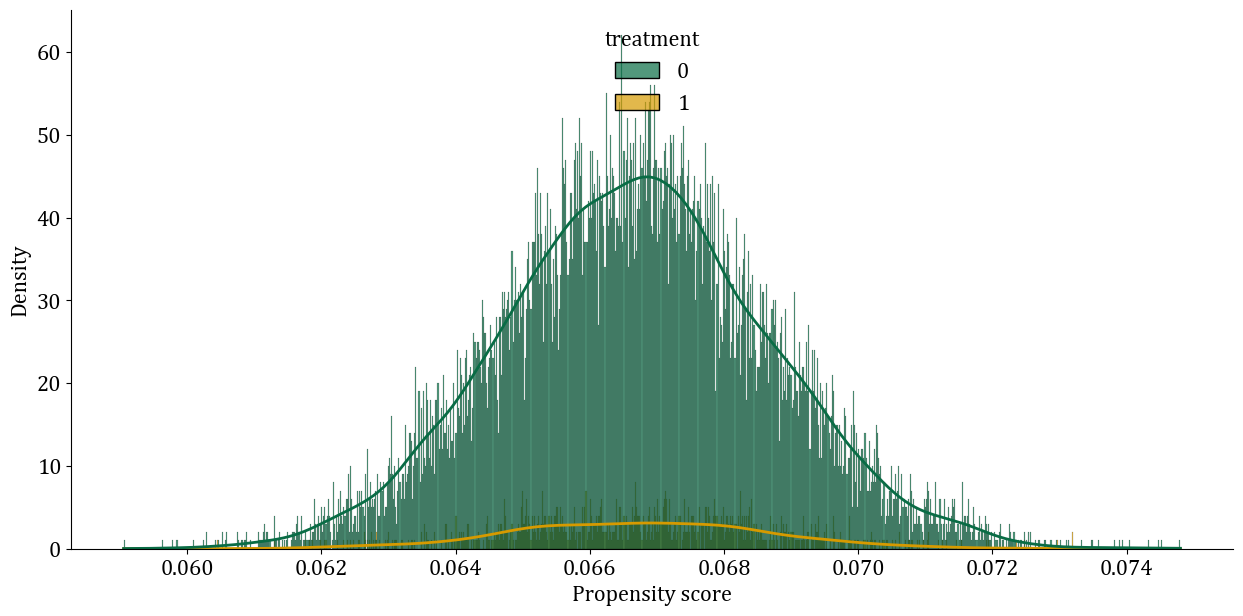

In [19]:
matcher.check_plot_common_support(df)

### <center> **`Matching`**

Ici, une variable est ultisée comme condition exacte de matching, ie, pour un idnividu traité en année t, un individu non-traité est recherché selon les caractéristiques en année t. La recherche d'un individu proche est donc réalisée au sein d'un échantillon restreint.

In [20]:
df_matched = matcher.match(df, exact_matching=['annee'])

Processing to matching row by row: 100%|██████████| 14995/14995 [00:03<00:00, 3775.48it/s] 


In [21]:
df_matched.head()

,id,treatment,CA,EBE,annee,propensity_score,annee_treatment,treatment_period,treated_over_time,matched_id,to_keep_after_matching
0,0,0,-0.269369,1.052234,2015,0.064571,2018.0,-3.0,1,"[1380, 1098]",1.0
1,0,0,-0.970757,0.756169,2016,0.064714,2018.0,-2.0,1,"[1380, 1098]",1.0
2,0,0,0.995060,-0.011135,2017,0.067294,2018.0,-1.0,1,"[1380, 1098]",1.0
3,0,1,-0.561805,-0.426336,2018,0.067161,2018.0,0.0,1,"[1380, 1098]",1.0
4,0,0,-0.375043,0.747260,2019,0.065071,2018.0,1.0,1,"[1380, 1098]",1.0


         Before matching  After matching  Attrition
Treated             1000            1000   0.000000
Control             2999            2268 -32.231041
Before matching, there were 1000 treated individuals and 2999 control individuals
After matching, there are 1000 treated individuals and 2268 control individuals


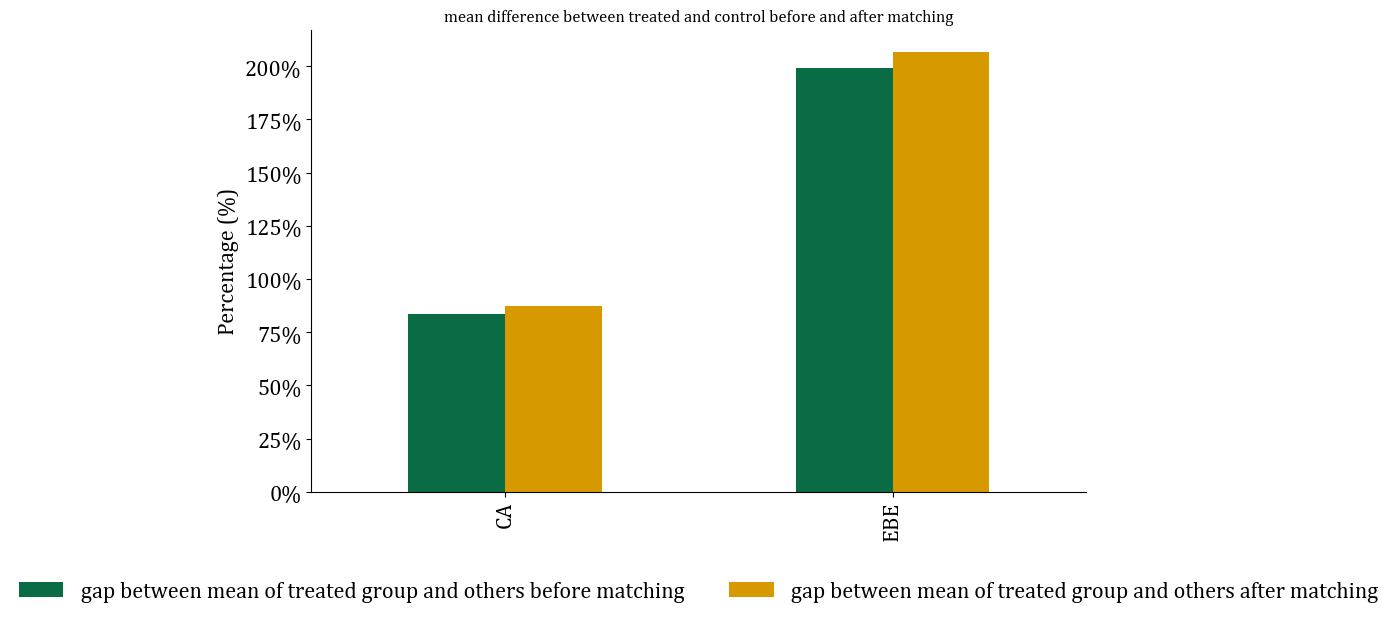

In [22]:
matcher.report(df_matched, var_to_plot=["CA", "EBE"])

###

### <center> Analysis

In [23]:
df_analysis = matcher.get_dataframe_for_analysis(df_matched)

Adding treated and its controls:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jvincent-galtie-adc\Documents\PropensityScoreMatching\PropensityScoreMatching\propensity_score_matching.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data_control.loc[:, "treatment_period"] = tmp_data_control.loc[
c:\Users\jvincent-galtie-adc\Documents\PropensityScoreMatching\PropensityScoreMatching\propensity_score_matching.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data_control.loc[:, "treatment_pe

In [24]:
df_analysis

,id,treatment,CA,EBE,annee,propensity_score,annee_treatment,treatment_period,treated_over_time,matched_id,to_keep_after_matching
0,0,0,-0.269369,1.052234,2015,0.064571,2018.0,-3.0,1,"[1380, 1098]",1.0
1,0,0,-0.970757,0.756169,2016,0.064714,2018.0,-2.0,1,"[1380, 1098]",1.0
2,0,0,0.995060,-0.011135,2017,0.067294,2018.0,-1.0,1,"[1380, 1098]",1.0
3,0,1,-0.561805,-0.426336,2018,0.067161,2018.0,0.0,1,"[1380, 1098]",1.0
4,0,0,-0.375043,0.747260,2019,0.065071,2018.0,1.0,1,"[1380, 1098]",1.0
...,...,...,...,...,...,...,...,...,...,...,...
10400,2081,0,0.891432,-0.518844,2015,0.068205,NaN,0.0,0,NaN,1.0
10401,2081,0,1.191486,-0.538550,2016,0.068423,NaN,1.0,0,NaN,1.0
10402,2081,0,-0.242441,-0.346244,2017,0.067198,NaN,2.0,0,NaN,1.0
10403,2081,0,0.621310,0.342572,2018,0.066404,NaN,3.0,0,NaN,1.0


### <center> **Plot results**

In [25]:
doublediff = double_diff_plot.DoubleDiff(var_group_distinction = "treated_over_time", var_time_series = "treatment_period") 

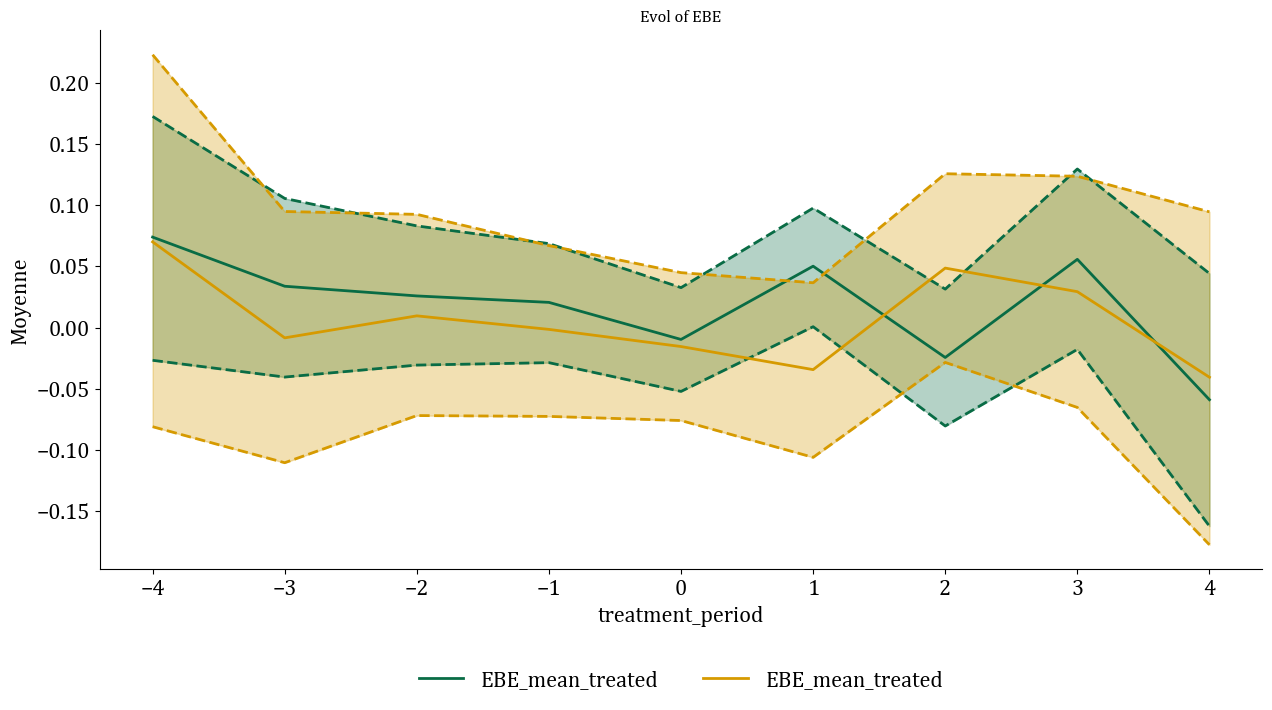

In [26]:
doublediff.plot_var_bootstrapped(df_analysis, var = "EBE")